In [94]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

# Final project

In this project I create a pipeline and try to extract knowledge from a city database (Open311 standard).



In [95]:
import random, pickle

import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import en_core_web_lg

from pprint import pprint

Define some utility functions.

In [96]:
# Flatten a list
flatten = lambda l: [item for sublist in l for item in sublist]

# argmax
def argmax(l):
    return max(range(len(l)), key=lambda j: l[j])

Define variables.

In [97]:
RANDOM_STATE = 123
random.seed(RANDOM_STATE)

#POS_FILTER = 'All'
POS_FILTER = 'NOUN'    # Topic modeling using just nouns gives more coherent topics https://www.aclweb.org/anthology/U15-1013.pdf
POS_TAGS = ['NOUN', 'VERB', 'ADJ', 'ADV']
CATEGORY = 'parks__playgrounds'


Load the large English corpus.

In [98]:
# Load the corpus
nlp = en_core_web_lg.load()

## Data

The data is from Bloominton city (Indiana) open access database. 

### Load the data

In [99]:
sample_size = 1000  # Maximum number of rows to retrieve
data_file = 'data/by_category/bloomington_{}.csv'.format(CATEGORY)
row_count = sum(1 for line in open(data_file)) - 1  # number of records in file (excludes header)

skip = []
if sample_size < row_count:
    skip = sorted(random.sample(range(1, row_count+1), row_count-sample_size))  # Exclude header from skip list
data = pd.read_csv(data_file, skiprows=skip, usecols=["ticket_id", "description", "category"],)

data

,ticket_id,category,description
0,38106,Parks & Playgrounds,wanted public info concerning skate park\nrepl...
1,38333,Parks & Playgrounds,wanting to sign up for line dance fitness clas...
2,58795,Parks & Playgrounds,Limestone Rail Trail: Ms. Tilford walked the ...
3,62084,Parks & Playgrounds,As a parent of a developmentally disabled adul...
4,62119,Parks & Playgrounds,BACC: Disappointed w/location & appearance of...
...,...,...,...
498,170238,Parks & Playgrounds,"Open air drug dealing, harassment and intimida..."
499,170262,Parks & Playgrounds,The fencing at Building Trades park o. Howe ha...
500,170286,Parks & Playgrounds,Karst farm park - one of the baby swings has s...
501,170415,Parks & Playgrounds,Dog poop station needs to be “serviced “


In [100]:
issues = data[data.description.notnull()]
issues = list(zip(issues.ticket_id, issues.description))  # (ticket_id, description)

issues[:3]

[(38106,
  'wanted public info concerning skate park\nreply-referred to parks and rec.'),
 (38333,
  "wanting to sign up for line dance fitness class, but was asked for donation\nreply- you don't have to give a donation to sign up for the class only pay the fee, attached corresponding webpage"),
 (58795,
  'Limestone Rail Trail:  Ms. Tilford walked the trail and reported barriers and no trespassing signs behind Dillman Treatment Plant.  She asked if that area is private property.  Farther south she said cows are grazing on the right-of-way.  She asked if the Rail Trail Conservancy might be able to help.  She is a member and trail supporter.')]

### Preprocess the data

1. Remove
     * stop words
     * named entities
     * entities that aren't nouns, verbs or adjectives (or other defined below)
1. Lemmatize

In [101]:

model_file_prefix = 'models/lda_{}_{}'.format(CATEGORY, sample_size)
token_file = '{}_{}_tokens'.format(model_file_prefix, POS_FILTER)
try:
    with open(token_file, 'rb') as f:
        cleaned_issues = pickle.load(f)
        print('\nLoaded tokens from file "{}"'.format(token_file))
except:
    cleaned_issues = []
    print('\nExtracting tokens ...')
    for i, issue in enumerate(issues):
        doc = nlp(issue[1])
        ents = [ent.text for ent in doc.ents]  # Named entities
        tokenized_sents = []
        for sent in doc.sents:
            tokenized_sents.append([
                (token.lemma_, token.pos_) for token in sent if (token.text not in ents) and (token.pos_ in POS_TAGS) and not token.is_stop
            ])
        d = dict([(tag, [token[0] for token in flatten(tokenized_sents) if token[1] == tag]) for tag in POS_TAGS])
        d['All'] = [token[0] for token in flatten(tokenized_sents)]
        cleaned_issues.append((issue[0], d))  # (ticket_id, token_dict)
        if i % 500 == 0:
            print(i, d['All'])

    print('\nSaving token file "{}"'.format(token_file))
    with open(token_file, 'wb') as f:
        pickle.dump(cleaned_issues, f, protocol=pickle.HIGHEST_PROTOCOL)



Loaded tokens from file "models/lda_parks__playgrounds_1000_NOUN_tokens"


In [102]:
issues[1]

(38333,
 "wanting to sign up for line dance fitness class, but was asked for donation\nreply- you don't have to give a donation to sign up for the class only pay the fee, attached corresponding webpage")

In [103]:
cleaned_issues[1]

(38333,
 {'NOUN': ['line',
   'dance',
   'fitness',
   'class',
   'donation',
   'reply-',
   'donation',
   'class',
   'fee',
   'webpage'],
  'VERB': ['want', 'sign', 'ask', 'sign', 'pay', 'attach', 'correspond'],
  'ADJ': [],
  'ADV': [],
  'All': ['want',
   'sign',
   'line',
   'dance',
   'fitness',
   'class',
   'ask',
   'donation',
   'reply-',
   'donation',
   'sign',
   'class',
   'pay',
   'fee',
   'attach',
   'correspond',
   'webpage']})

## Model training

Tun the issue descriptions into bags of words (BOW).

In [104]:
dictionary = corpora.Dictionary([doc[1]['NOUN'] for doc in cleaned_issues])
corpus = [dictionary.doc2bow(doc[1]['NOUN']) for doc in cleaned_issues]

#corpus[:3]

Train LDA (Latent Didrilecht Allocation) models for extracting topics.

In [105]:
lda_models = []
for num in range(6, 10): # num = how many topics
    model_file = '{}_{}_t{}'.format(model_file_prefix, POS_FILTER, num)
    try:
        model = gensim.models.ldamodel.LdaModel.load(model_file)
        print('Loaded model from file "{}"'.format(model_file))
    except:
        print('Training model {}'.format(model_file))
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num, iterations=50, random_state=RANDOM_STATE)
        model.save(model_file)
    lda_models.append(model)

Loaded model from file "models/lda_parks__playgrounds_1000_NOUN_t6"
Loaded model from file "models/lda_parks__playgrounds_1000_NOUN_t7"
Loaded model from file "models/lda_parks__playgrounds_1000_NOUN_t8"
Loaded model from file "models/lda_parks__playgrounds_1000_NOUN_t9"


Measure topic coherence and find the best model.

In [106]:
model_coherences = []
for i, model in enumerate(lda_models):
    cm = CoherenceModel(model=model, dictionary=dictionary, corpus=corpus, coherence='u_mass')
    model_coherences.append(cm.get_coherence())
    # print("Num topics: {}, Model coherence: {}\n".format(model.num_topics, cm.get_coherence()))

top_model = lda_models[argmax(model_coherences)]
pprint(top_model.print_topics(num_words=10))

[(0,
  '0.074*"park" + 0.026*"court" + 0.017*"lot" + 0.012*"city" + 0.012*"shelter" '
  '+ 0.011*"year" + 0.011*"tennis" + 0.010*"parking" + 0.010*"people" + '
  '0.010*"playground"'),
 (1,
  '0.024*"playground" + 0.022*"park" + 0.019*"area" + 0.016*"kid" + '
  '0.016*"trail" + 0.015*"slide" + 0.015*"dog" + 0.013*"thank" + 0.011*"foot" '
  '+ 0.010*"water"'),
 (2,
  '0.085*"dog" + 0.042*"park" + 0.015*"swing" + 0.015*"area" + 0.014*"owner" + '
  '0.014*"light" + 0.013*"child" + 0.011*"playground" + 0.009*"trail" + '
  '0.009*"people"'),
 (3,
  '0.060*"park" + 0.024*"water" + 0.023*"tree" + 0.015*"playground" + '
  '0.015*"fountain" + 0.013*"dog" + 0.013*"area" + 0.011*"grass" + '
  '0.010*"court" + 0.010*"thank"'),
 (4,
  '0.044*"park" + 0.024*"area" + 0.020*"trail" + 0.020*"tree" + 0.018*"water" '
  '+ 0.013*"thank" + 0.012*"dog" + 0.011*"year" + 0.010*"fountain" + '
  '0.008*"time"'),
 (5,
  '0.033*"park" + 0.016*"court" + 0.015*"tree" + 0.014*"city" + 0.013*"thank" '
  '+ 0.010*"ten

## Model interpretation


### Most representative issues

Find the most representative issues for each topic.

In [107]:
# Find the dominant (=most likely) topic for each issues
lda_corpus = [(cleaned_issues[i][0], max(prob, key=lambda y: y[1])) for i, prob in enumerate(top_model[corpus])]

# Find the most representative issues for each topic
thresh = 0.0125                # Only show words above certain threshold
M = 3                          # How many do
topic_top_docs = []
for i in range(0, top_model.num_topics):
    docs = [y[0] for y in sorted([x for x in lda_corpus if x[1][0] == i], key=lambda x: x[1], reverse=True)]
    topic_words = [x[0] for x in top_model.show_topic(i, topn=100) if x[1] > thresh]
    topic_top_docs.append((i, topic_words, docs[:M]))


for (topic_id, keywords, issue_ids) in topic_top_docs:
    print('\nTopic id: {},'.format(topic_id))
    print("\nKeywords: '{}'".format("', '".join(keywords)))
    print('\nIssues:')
    issues = [x[:100].replace("\n", " ") + " ..." for x in data[data.ticket_id.isin(issue_ids)].description.values]
    print("*", "\n* ".join(issues))



Topic id: 0,

Keywords: 'park', 'court', 'lot'

Issues:
* Hello,  I'm a frequent user of Bryan Park, and I'm concerned about the city truck that is being driv ...
* Homeless man and friends congregating in the building and trades park - upper shelter house. Drinkin ...
* I love Bryan Park and have walked there nearly every morning for many years.  In the past year or so ...

Topic id: 1,

Keywords: 'playground', 'park', 'area', 'kid', 'trail', 'slide', 'dog', 'thank'

Issues:
* Hello,  There is currently a safety issue at Sherwood Oaks Park.  Below the big blue slide on the pl ...
* The small karst feature (sinkhole) on the northeast side of Weimer Lake (in Wapehani Park) has great ...
* On August 21st, I reported a homeless camp at Wapehani Park. It was examined and reported back to me ...

Topic id: 2,

Keywords: 'dog', 'park', 'swing', 'area', 'owner', 'light', 'child'

Issues:
* Hello,   I've recently stopped going to the Ferguson Dog Park on the Northside of town because it is ..

### Word Cloud

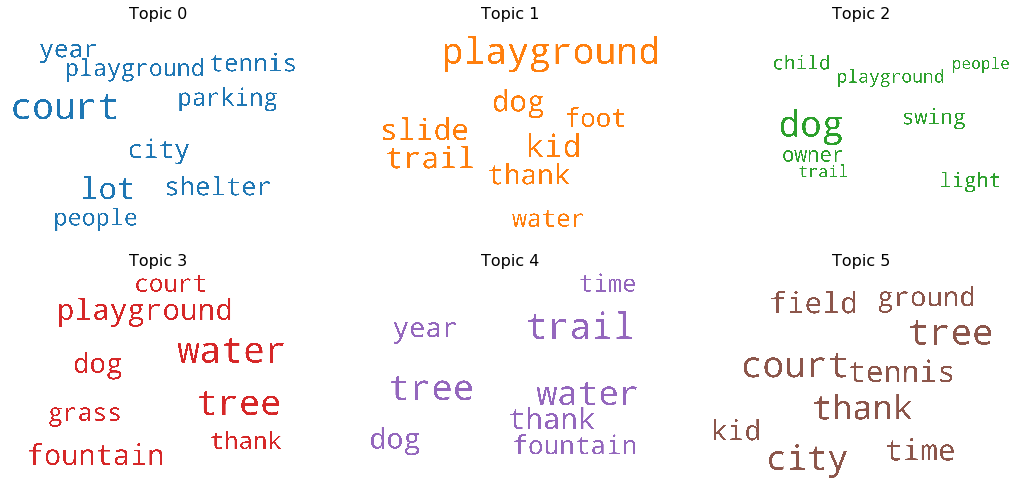

In [108]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

stop_words = set(['park', 'area'])
cloud = WordCloud(background_color='white', width=2500, height=1800, max_words=10, 
                  colormap='tab10', color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)

topics = top_model.show_topics(formatted=False)
fig, axes = plt.subplots(2,3, figsize=(15,7), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict([x for x in topics[i][1] if not x[0] in stop_words])  # Remove stop words
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### pyLDavis

In [109]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(top_model, corpus, dictionary=top_model.id2word)
pylda_file = '{}_pylda.html'.format(model_file_prefix)
pyLDAvis.save_html(vis, pylda_file)

#print(pylda_file)
#vis

[Link to pyLDAvis visualization](https://eevalaiho.github.io/HyNLP/lda_parks__playgrounds_1000_pylda.html)

In [110]:
from IPython.display import IFrame

IFrame(src='./lda_parks__playgrounds_1000_pylda.html', width=1350, height=860)
